# LeNet 5

In [14]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [15]:
%matplotlib widget

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [17]:
test_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.1307,], [0.3081,])
    ]
)

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((32, 32)),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.1307,], [0.3081,])
    ]
)

train_set = MNIST(root="data", train=True, download=True, transform=train_transform)
test_set = MNIST(root="data", train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

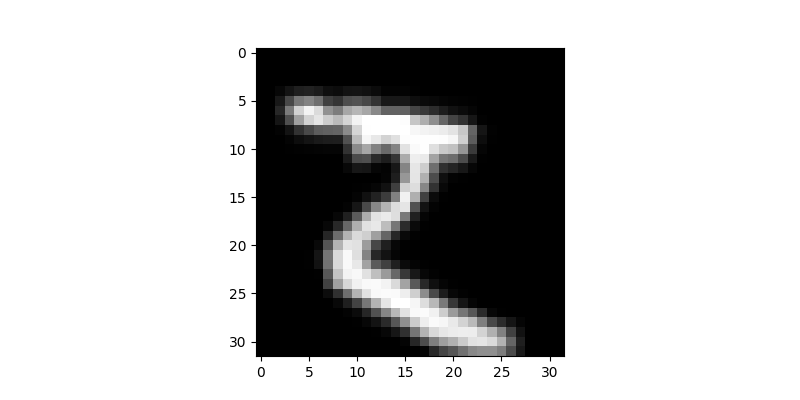

In [18]:
plt.gray()
plt.figure(figsize=(8, 4))
plt.imshow(train_set[0][0][0])

In [25]:
class LeNet5Model(nn.Module):
    def conv_block(
        self,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=nn.ReLU(),
        pooling=nn.AvgPool2d(2, 2),
    ):
        layers = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size, stride, padding),
        )

        if activation is not None:
            layers.add_module("activation", activation)
        if pooling is not None:
            layers.add_module("pooling", pooling)
        return layers

    def linear_block(self, out_features, activation=nn.ReLU()):
        layers = nn.Sequential(
            nn.LazyLinear(out_features),
        )

        if activation is not None:
            layers.add_module("activation", activation)
        return layers

    def __init__(self):
        super(LeNet5Model, self).__init__()

        self.layers = nn.Sequential(
            self.conv_block(6),
            self.conv_block(16),
            nn.Flatten(),
            self.linear_block(120),
            self.linear_block(84),
            self.linear_block(10, activation=None),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [28]:
class LeNet5(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = LeNet5Model()
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def _calculate_loss(self, batch, mode="train"):
        x, y = batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        acc = (preds.argmax(dim=-1) == y).float().mean()
        
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch)

    def test_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="test")
    

In [30]:
model = LeNet5()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | LeNet5Model | 0      | train
----------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
